In [0]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
import joblib

### Data loading

In [2]:
path = "./Datasets/CIFAR10_data/"
# path = "E:/Datasets/CIFAR10_data/"

device = 'cuda'
num_workers = 0
batch_size = 20

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10(path, train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(path, train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
# classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

0it [00:00, ?it/s]

100%|█████████▉| 170188800/170498071 [00:11<00:00, 17772642.68it/s]

Extracting ./Datasets/CIFAR10_data/cifar-10-python.tar.gz to ./Datasets/CIFAR10_data/
Files already downloaded and verified


### Network

In [0]:
class Architecture(nn.Module):

    def __init__(self):
        super(Architecture, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(32, 64, kernel_size=3, padding=2)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, padding=2)

        self.pool = nn.MaxPool2d(2)

        self.fc_1 = nn.Linear(64 * 2 * 2, 256)
        self.fc_2 = nn.Linear(256, 10)

        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.pool(self.tanh(self.conv1(x)))
        x = self.pool(self.tanh(self.conv2(x)))
        x = self.pool(self.tanh(self.conv3(x)))
        x = self.pool(self.tanh(self.conv4(x)))
        x = self.pool(self.tanh(self.conv5(x)))
        x = self.pool(self.tanh(self.conv6(x)))
        x = x.view(-1, 64 * 2 * 2)
        x = self.tanh(self.fc_1(x))
        x = self.fc_2(x)
        return x

model = Architecture()
model.to(device)

CE = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.02)

In [4]:
train_loss_plt, valid_loss_plt = [], []
test_accuracy_plt = []
test_loss_plt = []
n_epochs = 100
for epoch in range(n_epochs):
    train_loss, test_loss = 0, 0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = CE(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    train_loss_plt.append(train_loss)

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = CE(output, target)

            test_loss += loss.item() * data.size(0)
            _, pred = torch.max(output, 1)
            correct = np.squeeze(pred.eq(target.data.view_as(pred)))
            for i in range(len(target)):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    test_loss = test_loss / len(test_loader.dataset)
    test_loss_plt.append(test_loss)
    
    test_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
    test_accuracy_plt.append(test_accuracy)

    print('Epoch:', (epoch + 1), '\tTrain Loss:', train_loss,' | Test Loss:', test_loss,' | Test Acc.:',test_accuracy)

170500096it [00:30, 17772642.68it/s]                               

Epoch: 1 	Train Loss: 1.7136026488780975  | Test Loss: 1.3780939165353776  | Test Acc.: 48.87
Epoch: 2 	Train Loss: 1.2934689541339874  | Test Loss: 1.1932801386117935  | Test Acc.: 56.66
Epoch: 3 	Train Loss: 1.1269749299287797  | Test Loss: 1.1133525326251983  | Test Acc.: 59.89
Epoch: 4 	Train Loss: 1.023576014983654  | Test Loss: 1.0658209847211837  | Test Acc.: 61.91
Epoch: 5 	Train Loss: 0.9482072125673294  | Test Loss: 1.0383855511546134  | Test Acc.: 63.09
Epoch: 6 	Train Loss: 0.8870006301522255  | Test Loss: 1.0253390951156616  | Test Acc.: 63.88
Epoch: 7 	Train Loss: 0.8351006459116935  | Test Loss: 1.0202298134565353  | Test Acc.: 63.99
Epoch: 8 	Train Loss: 0.7899089081048966  | Test Loss: 1.0224459275603295  | Test Acc.: 64.1
Epoch: 9 	Train Loss: 0.748813375133276  | Test Loss: 1.0271416900753976  | Test Acc.: 64.46
Epoch: 10 	Train Loss: 0.7106996516346932  | Test Loss: 1.0343672831058501  | Test Acc.: 64.99
Epoch: 11 	Train Loss: 0.6754823635876179  | Test Loss: 1.0471

### Saving

In [0]:
joblib.dump(train_loss_plt, 'train_loss_plt_q2_tanh.sav')
joblib.dump(test_loss_plt, 'test_loss_plt_q2_tanh.sav')
joblib.dump(test_accuracy_plt, 'test_accuracy_plt_q2_tanh.sav')
torch.save(model.state_dict(), "model_q2_tanh.pt")

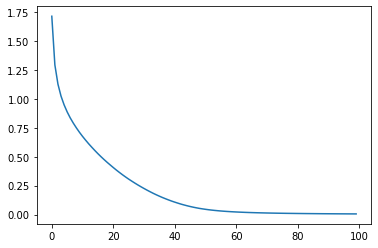

In [6]:
plt.plot(np.arange(len(train_loss_plt)),train_loss_plt)

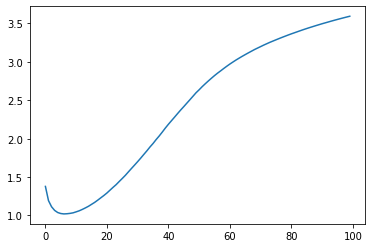

In [7]:
plt.plot(np.arange(len(test_loss_plt)),test_loss_plt)

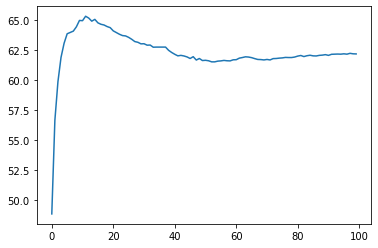

In [8]:
plt.plot(np.arange(len(test_accuracy_plt)),test_accuracy_plt)

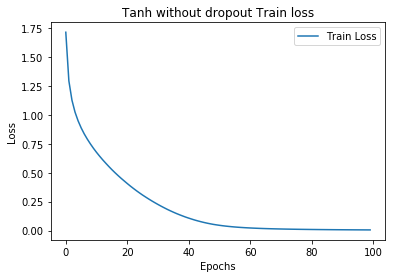

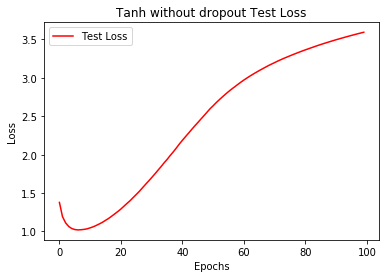

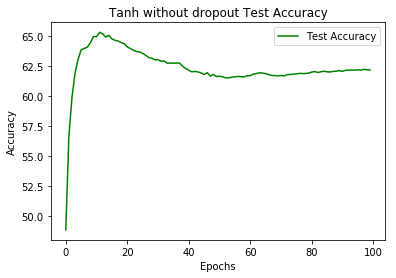

In [2]:
import joblib
import matplotlib.pyplot as plt
import numpy as np

train_loss_plt = joblib.load('train_loss_plt_q2_tanh.sav')
test_loss_plt = joblib.load('test_loss_plt_q2_tanh.sav')
test_accuracy_plt = joblib.load('test_accuracy_plt_q2_tanh.sav')

plt.title('Tanh without dropout Train loss')
plt.plot(np.arange(len(train_loss_plt)),train_loss_plt,label = 'Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.title('Tanh without dropout Test Loss')
plt.plot(np.arange(len(test_loss_plt)),test_loss_plt,color='r',label = 'Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.title('Tanh without dropout Test Accuracy')
plt.plot(np.arange(len(test_accuracy_plt)),test_accuracy_plt,color='g',label = 'Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()